# Introduction

make graphs such that there is a clear center graph  and try to reconstruct that

### Ipython Notebook init

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1) # use 2 for more info
BABELDRAW=False

# constructing graphs

In [2]:
'''
import networkx as nx
from graphlearn.utils import draw
def string_to_graph(string):
    #string+= ''.join(reversed(string))
    g=nx.path_graph(len(string))
    for i in range(len(string)):
        g.node[i]['label']=string[i]
    for i in range(len(string)-1): # lol i need to set edge labels ... eden bug?
        g[i][i+1]['label']=''
    return g

def strings_to_graph(li):
    for e in li: 
        yield string_to_graph(e)
        


# the plan is to create stuff like this:
# aaa -> baa aba aab, bba bab abb  but stuff with > 50% b :) 

def generate_strings(stri='',has=0, wanted_strilen=5, max_wanted_wan=3):
    result=[]    
    # am i done? 
    if has==max_wanted_wan:
        return [stri+'0'*(wanted_strilen-len(stri))]
    if len(stri)-wanted_strilen == max_wanted_wan-has:
        return [stri+'1'*(max_wanted_wan-has)]
    if len(stri)==wanted_strilen:
        return [stri]

    # 2 possibilities: 1 or 0
    result+=generate_strings(stri= stri+'0', has=has,wanted_strilen=wanted_strilen,max_wanted_wan = max_wanted_wan)
    result+=generate_strings(stri= stri+'1', has=has+1,wanted_strilen=wanted_strilen,max_wanted_wan = max_wanted_wan)
    return result
    

#generate_strings()


strings = generate_strings(wanted_strilen=10, max_wanted_wan=5)


def get_graphs():
    return strings_to_graph(strings)

def get_regression_values():
    #scaling for lazyness in scoregraph
    return [s.count('0')*.1 for s in strings]
'''

"\nimport networkx as nx\nfrom graphlearn.utils import draw\ndef string_to_graph(string):\n    #string+= ''.join(reversed(string))\n    g=nx.path_graph(len(string))\n    for i in range(len(string)):\n        g.node[i]['label']=string[i]\n    for i in range(len(string)-1): # lol i need to set edge labels ... eden bug?\n        g[i][i+1]['label']=''\n    return g\n\ndef strings_to_graph(li):\n    for e in li: \n        yield string_to_graph(e)\n        \n\n\n# the plan is to create stuff like this:\n# aaa -> baa aba aab, bba bab abb  but stuff with > 50% b :) \n\ndef generate_strings(stri='',has=0, wanted_strilen=5, max_wanted_wan=3):\n    result=[]    \n    # am i done? \n    if has==max_wanted_wan:\n        return [stri+'0'*(wanted_strilen-len(stri))]\n    if len(stri)-wanted_strilen == max_wanted_wan-has:\n        return [stri+'1'*(max_wanted_wan-has)]\n    if len(stri)==wanted_strilen:\n        return [stri]\n\n    # 2 possibilities: 1 or 0\n    result+=generate_strings(stri= stri+'0

In [3]:

###########################3
##   MAKE DATA
###########################

import random
def swap_two_characters(seq):
    '''define a function that swaps two characters at random positions in a string '''
    line = list(seq)
    id_i = random.randint(0,len(line)-1)
    id_j = random.randint(0,len(line)-1)
    line[id_i], line[id_j] = line[id_j], line[id_i]
    return ''.join(line)

def one_run(length=26, depth=5):
    text = ''.join([str(unichr(97+i)) for i in range(length)])
    reference = '%s' % text
    seqs = []
    seqs.append(text)
    for i in range(depth):
        text = swap_two_characters( random.choice(seqs) )
        if text != reference:
            if text not in seqs:
                seqs.append( text )
    return seqs

def guard_seq(seq):
    return seq#'<<'+seq+'>>'

def guard_seqs(seqs):
    return [guard_seq(seq) for seq in seqs]

def make_data(num_runs=3, trim_top=3, length=26, depth=5):
    data = list()
    for i in range(num_runs):
        random.seed(i)
        seqs = one_run(length=length, depth=depth)
        data += seqs[trim_top:]
    return guard_seqs(data)


###########################3
##   string to graph
###########################

import networkx as nx
def sequence_to_graph(seq):
    '''convert a sequence into a EDeN 'compatible' graph
    i.e. a graph with the attribute 'label' for every node and edge'''
    G = nx.Graph()
    for id,character in enumerate(seq):
        G.add_node(id, label = character )
        if id > 0:
            G.add_edge(id-1, id, label = '-')
    return G

def pre_process(iterable):
    for seq in iterable:
        yield sequence_to_graph(seq)
        
###########################3
##   string to graph
###########################

def extract_seq(graph, root):
    seq = []
    seq.append(graph.node[root]['label'])
    #start from root and follow links without jittering
    neighs = graph.neighbors(root)
    curr = neighs[0]
    prev = root
    seq.append(graph.node[curr]['label'])
    while True:
        neighs = graph.neighbors(curr)
        if len(neighs)== 1:
            break
        if neighs[0] == prev:
            after = neighs[1]
        else:
            after = neighs[0]
        curr, prev = after, curr
        seq.append(graph.node[curr]['label'])
    return ''.join(seq)

def extract_label_sequence(graph):
    boundaries=list()
    for u in graph.nodes():
        if len(graph.neighbors(u))==1:
            boundaries.append(u)
    assert(len(boundaries)==2)
    seq1 = extract_seq(graph, boundaries[0])
    seq2 = extract_seq(graph, boundaries[1])
    if seq1 < seq2:
        return seq1
    else:
        return seq2


def get_estihelper(seed):
    l=[]
    for i in range(len(seed)):
        l+=[ seed[i:]+seed[:i] ]
        l+=[ seed[i:]+seed[:i][::-1] ] # should be the mirror version... hope it helps
    return l
    
length=12
flength=float(length)
ref = ''.join([str(unichr(97+i)) for i in range(length)])
ref = guard_seq(ref)
seqs = make_data(num_runs=1000, trim_top=2, length=length, depth=length)
# seqs+=get_estihelper(ref)

def get_graphs():
    return  list(pre_process(seqs))

def get_regression_values():
    def compare(x,ref):
        
        return max( sum([ 1  for i,y in enumerate(x) if ref[i]==y ])/flength,
                   sum([ 1  for i,y in enumerate(x[::-1]) if ref[i]==y ])/flength)
    
    return [compare(x,ref) for x in seqs]  

#for score,seq in zip(get_regression_values(),seqs):
    #print score,seq

In [4]:
%%time
from graphlearn.graphlearn import  Sampler
from graphlearn import estimate
from eden.graph import Vectorizer
sampler=Sampler(radius_list=[0,1], 
                #estimator=estimate.OneClassEstimator(nu=.90, cv=4, n_jobs=-1),
                #estimator=estimate.Regressor(),
                #vectorizer=Vectorizer(complexity=4),
                thickness_list=[1],
                min_cip_count=2, 
                min_interface_count=2)
sampler.fit(get_graphs(),regression_targets=get_regression_values())


# lets look at a few stats about the trained sampler
print('graph grammar stats:')
n_instances, interface_counts, core_counts, cip_counts = sampler.grammar().size()
print('#instances: %d   #interfaces: %d   #cores: %d   #core-interface-pairs: %d' % (n_instances, interface_counts, core_counts, cip_counts))

# dumps the sampler for later use. This is not mandatory :) 
sampler.save('../../tmp/sampler.ge')

graph grammar stats:
#instances: 9789   #interfaces: 78   #cores: 737   #core-interface-pairs: 8783
CPU times: user 1min 30s, sys: 3.98 s, total: 1min 34s
Wall time: 1min 49s


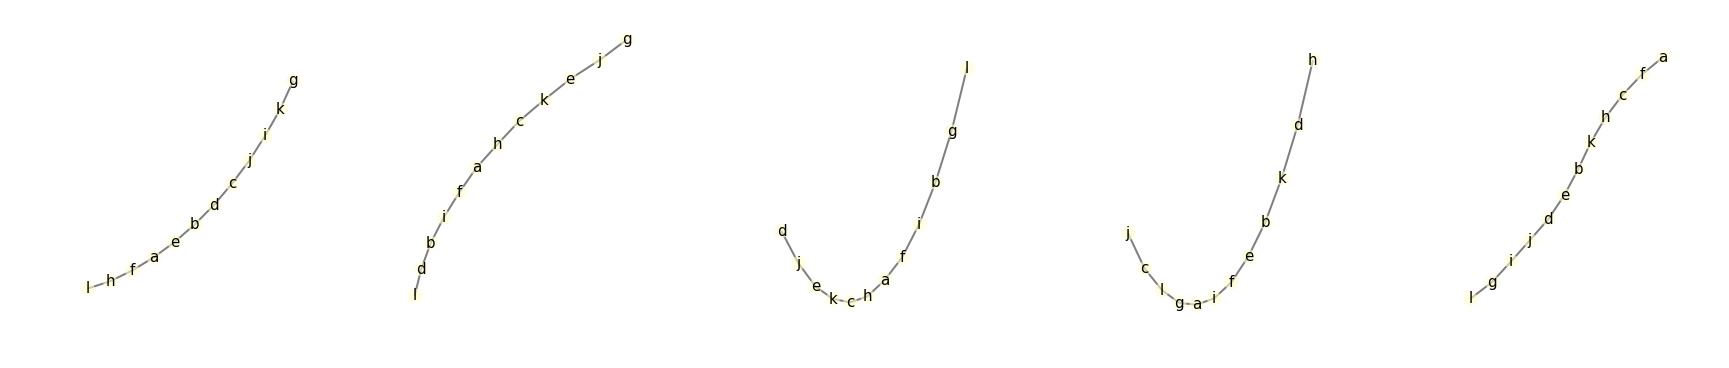

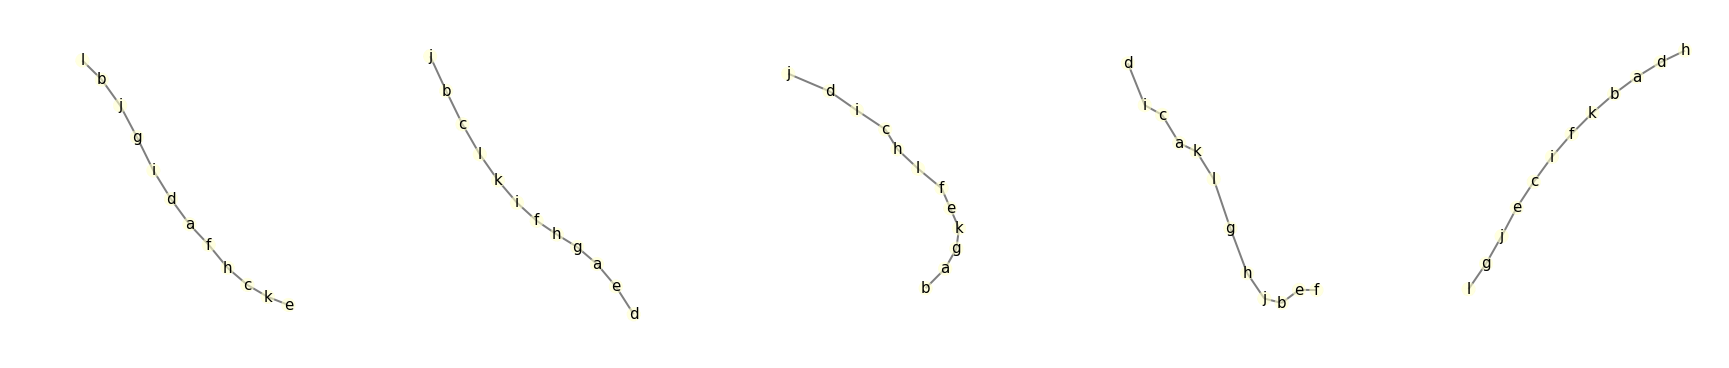

In [5]:
# draw high scoring graphs oo
from graphlearn.utils import draw
v=sampler.vectorizer
matrix=v.transform(get_graphs())
l = [(sampler.estimatorobject.predict(g), i) for i,g in enumerate(matrix)]
l.sort(key=lambda x: x[0])
graphs=list(get_graphs())
res=[ graphs[x[1]] for x in l[:10] ]


draw.graphlearn(res)

# Grammar Inspection

If you are interested in the generated grammar, there are 
two useful tools available. 
You can draw the grammar directly, as seen below.
draw_grammar_stats will collect statistics about the grammar and visualize them nicely.

interface id: 268496 [307 options]


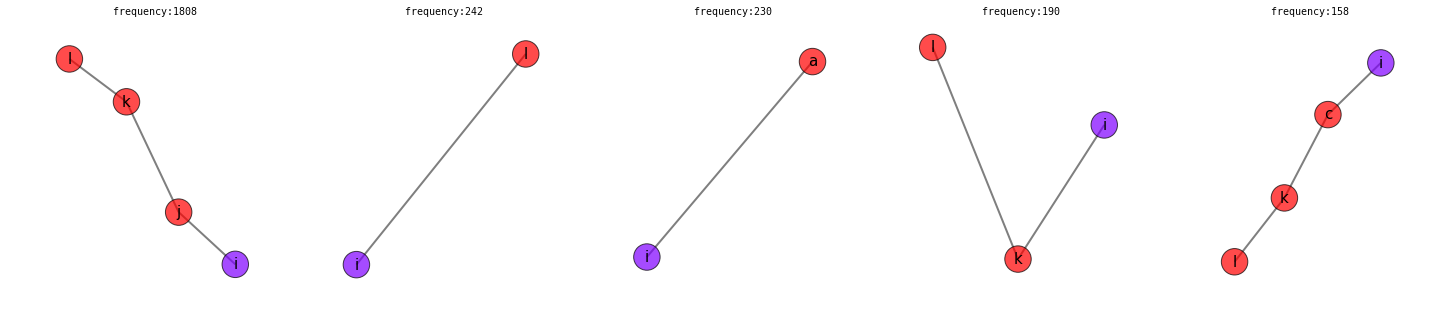

interface id: 660238 [300 options]


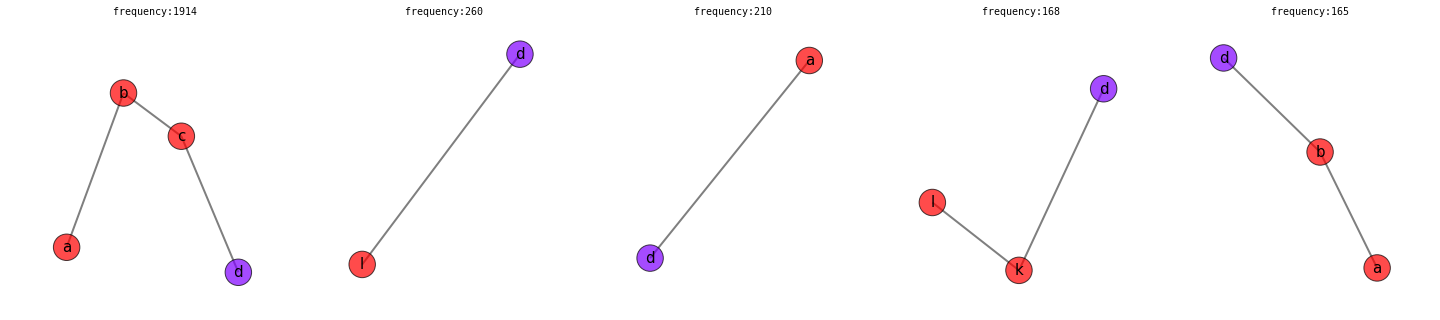

interface id: 30808 [218 options]


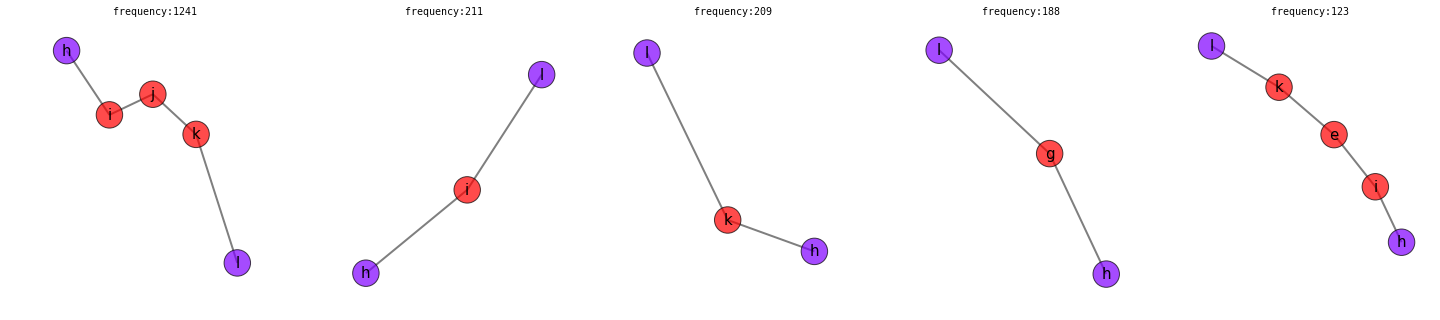

interface id: 680164 [217 options]


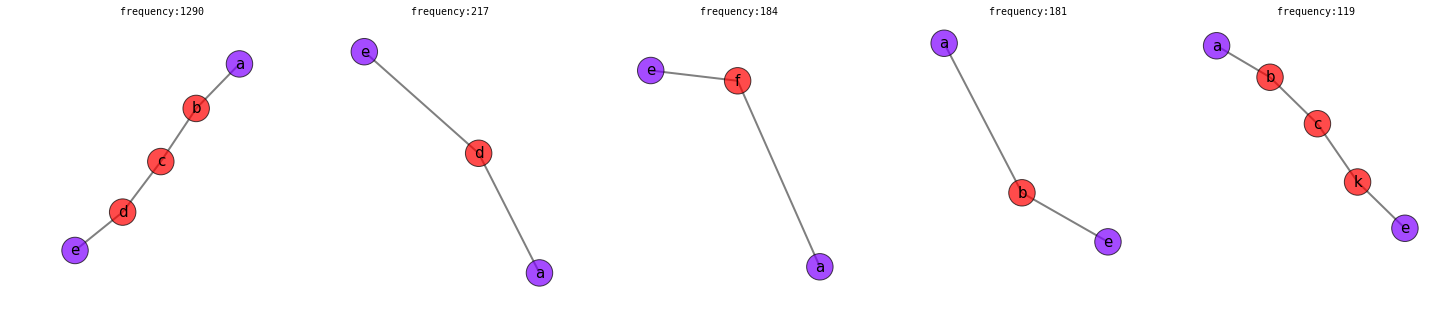

interface id: 1033748 [216 options]


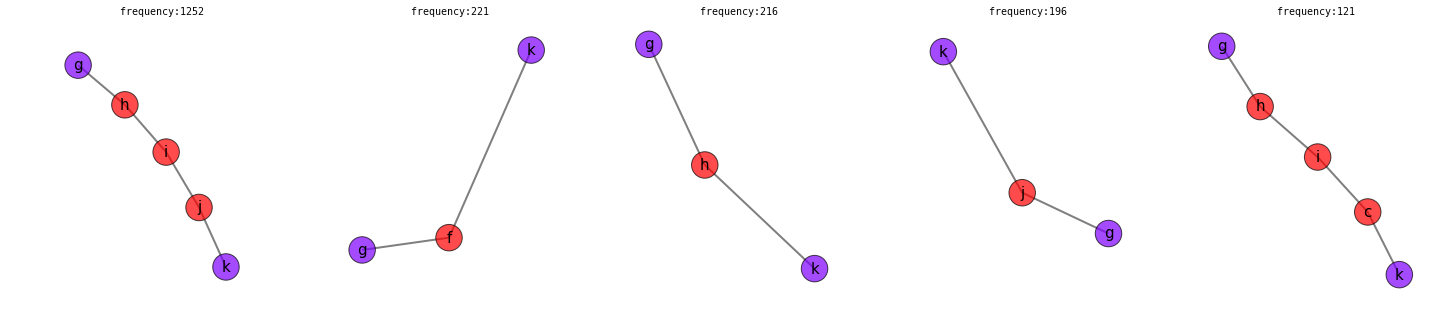

interface id: 867800 [214 options]


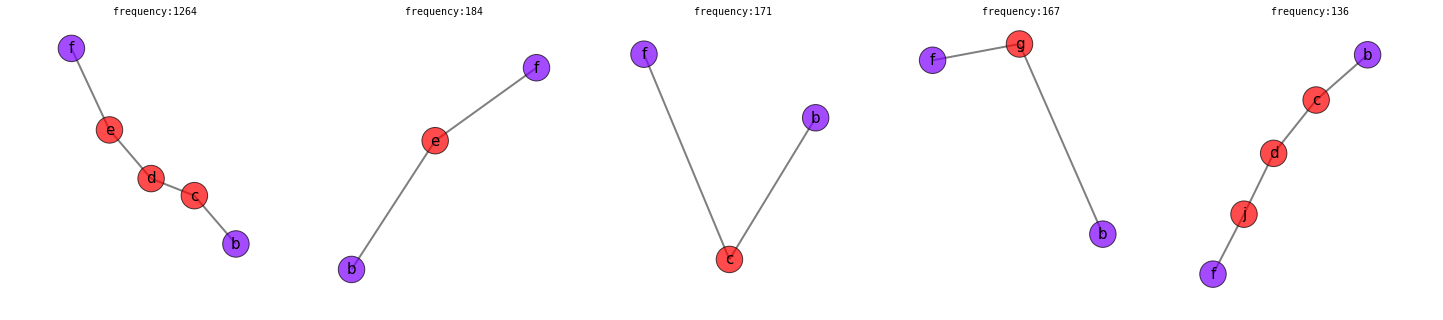

interface id: 92952 [214 options]


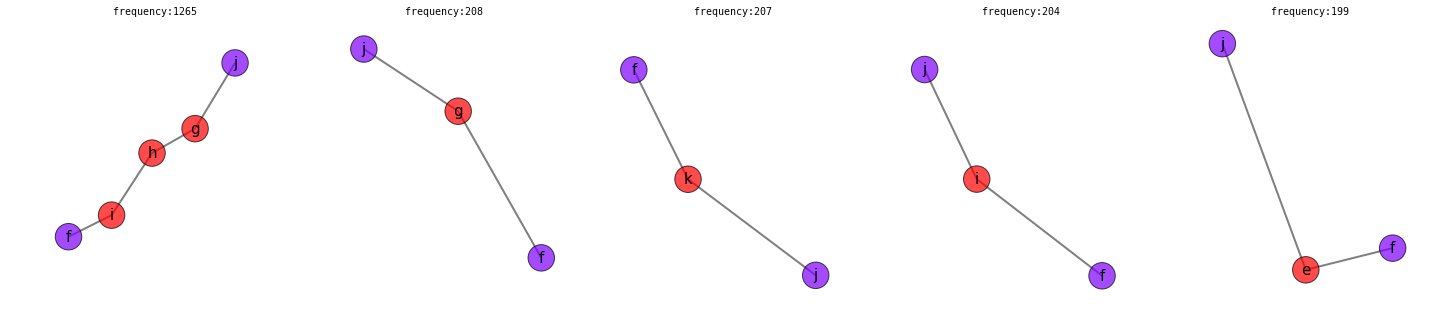

In [6]:
from graphlearn.utils.draw import draw_grammar
# draw one group of graph fragments (CIPS)
draw_grammar(sampler.grammar().productions, contract=True,
             n_productions=7,
             n_graphs_per_line=5,
             n_graphs_per_production=5,
             size=5, 
             colormap='rainbow', 
             node_border=1, 
             vertex_alpha=0.7, 
             edge_alpha=0.5, 
             node_size=700)
#from graphlearn.utils.draw import draw_grammar_stats
#draw_grammar_stats(sampler.lsgg.productions, size=(10,5))

# Sample

Sampling with default options will work just fine if you are just interested
in new graphs. The n_steps parameter defines 
how many attempts of altering a graph are made.

##### Options that will influence the acceptance of a generated graph:

In each sampling step, a graph is altered and scored.
An accept function decides if we keep the new graph. The parameters listed here 
influence this acceptance function.

improving_threshold=.5,
after this fraction of steps, only improvements are accepted  ---
improving_linear_start=0.0, 
graphs are accepted with a probability depending on their score. From this fraction it becomes gradually harder for worse graphs to be accepted. ---
accept_static_penalty=0.0, 
graphs that are worse than their predecessors get this penalty (on top of the other two options).

##### Options for choosing the new fragment:

The fragment chosen for alteration can be influenced by the acceptable node parameter (see sampler init). 
In general it will be chosen randomly. The fragment it will be replaced with can be influenced however:

probabilistic_core_choice=False, with this option we choose the fragment according to its frequency in the grammar.  ---
score_core_choice= True, choose the fragment according to score ( given by estimator ), the better the score, the more likely it is for a fragment to be picked ---
max_size_diff=1, maximum size difference between the seed graph and every graph generated graph. if choosing a fragment will violate the 
size constraints, it will not be selected.

#####  Output multiple graphs (along the sample path):


burnin=10, ignore the first burnin graphs for the nsamples parameter ---
n_samples=n_samples, from burnin to end of sample, collect this many samples. ---
keep_duplicates=True, duplicates may be deleted ---
include_seed=True,  seed will be the first graph in the output list. 

##### Collect additional information during sampling, that may help debugging

monitor=True, after sampling acessible via eg sampler.monitors[1][9] (first graph, ninth step)
                        
##### Output format 
sample() will yield a list of graph for each input graph.

In [7]:
%%time
from itertools import islice
from graphlearn.graphlearn import  Sampler
sampler=Sampler()
sampler.load('../../tmp/sampler.ge')

# picking graphs
graphs = get_graphs()
id_start=4
id_end=id_start+12
input_graphs = islice(graphs,id_start,id_end)

# sample parameters
n_steps=300 # how many steps
n_samples=4 # collect this many samples during the process

graphs = sampler.sample(input_graphs,
                        n_steps=n_steps, n_samples=n_samples,
                        probabilistic_core_choice=True,
                        score_core_choice= False,
                        size_diff_core_filter=0,
                        burnin=10,
                        include_seed=True,
                        proposal_probability = False,
                        improving_threshold=.5, 
                        improving_linear_start=0.0,
                        accept_static_penalty=0.0,
                        n_jobs=1,
                        select_cip_max_tries=200,
                        keep_duplicates=True,  
                        monitor=True)

CPU times: user 4.82 s, sys: 60 ms, total: 4.88 s
Wall time: 4.87 s


Graph id: 4


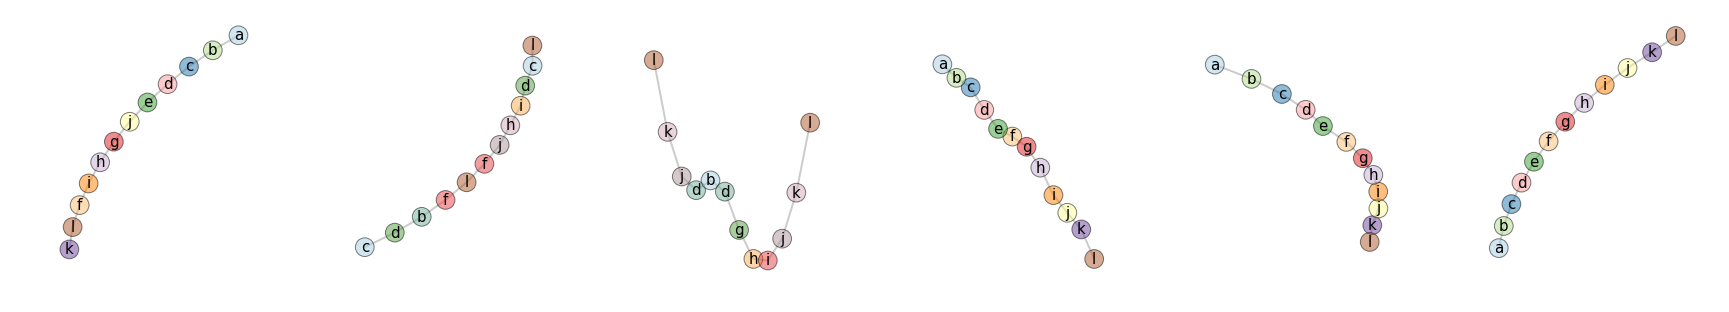

Graph id: 5


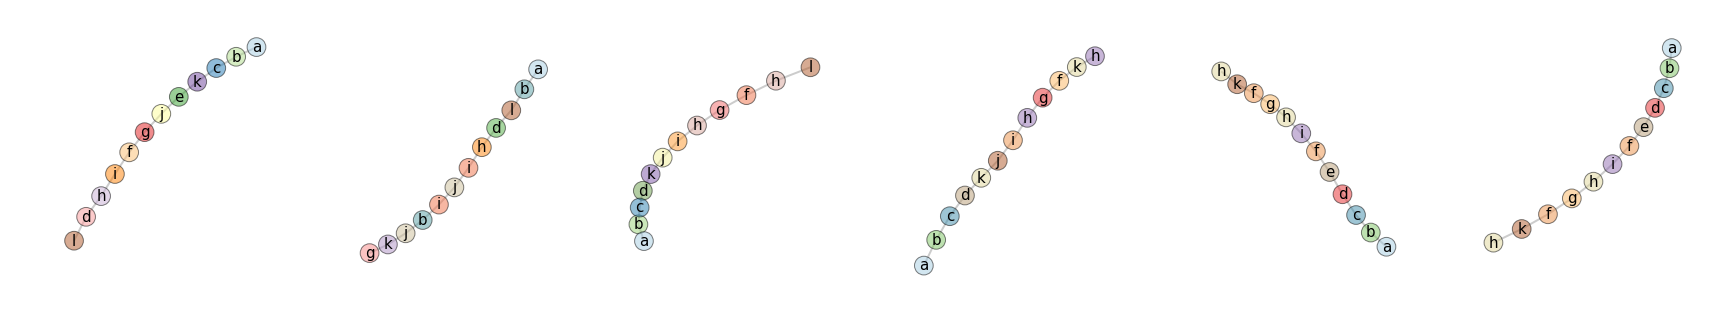

Graph id: 6


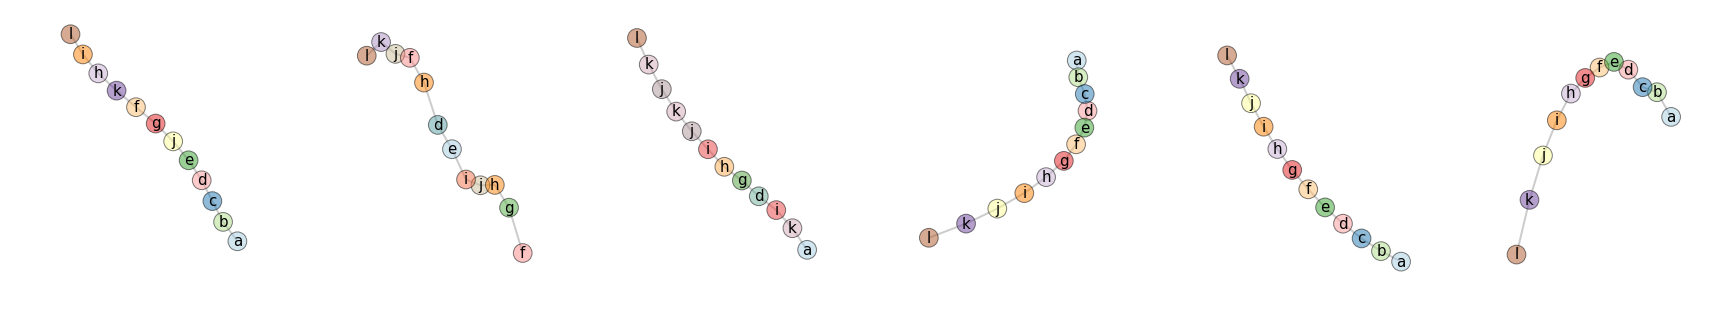

Graph id: 7


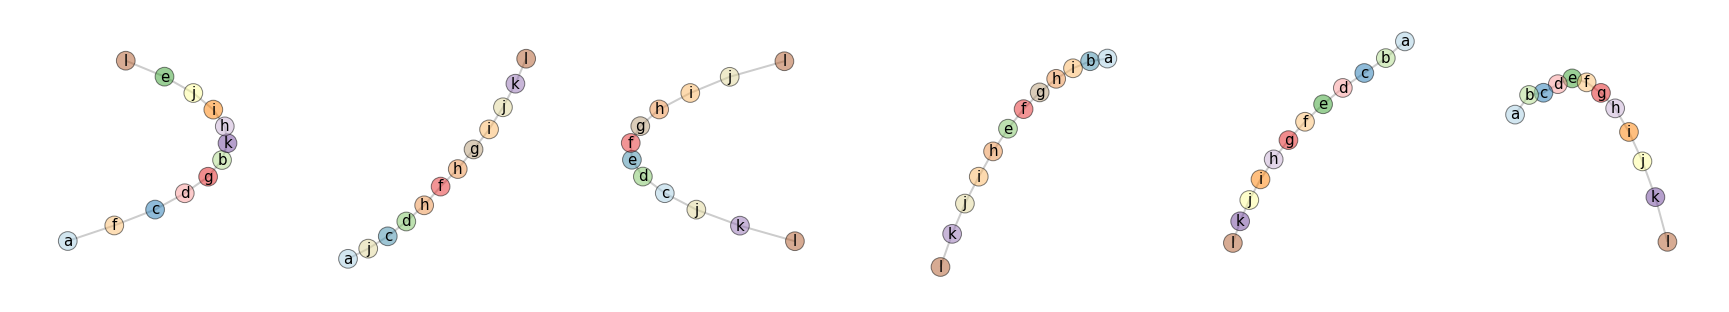

Graph id: 8


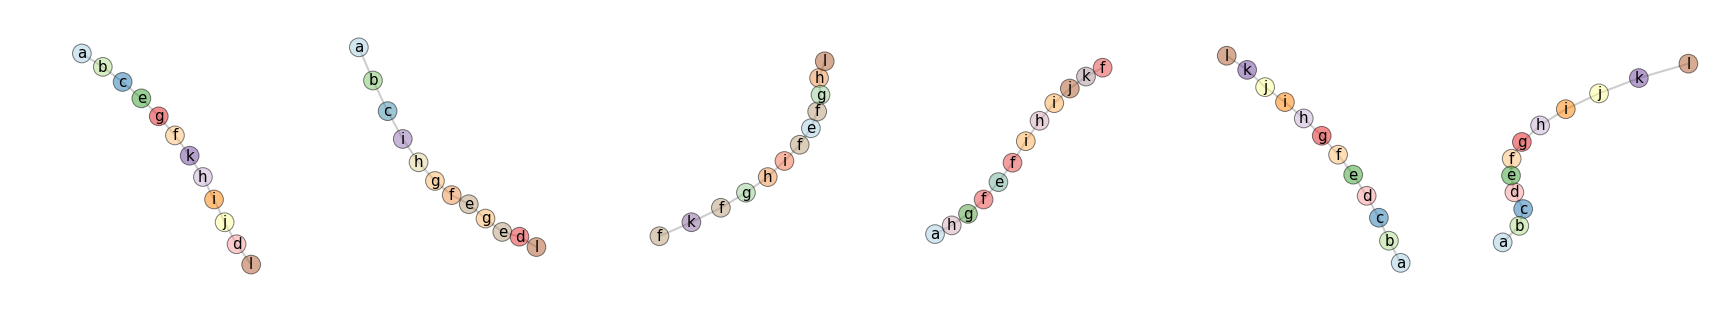

Graph id: 9


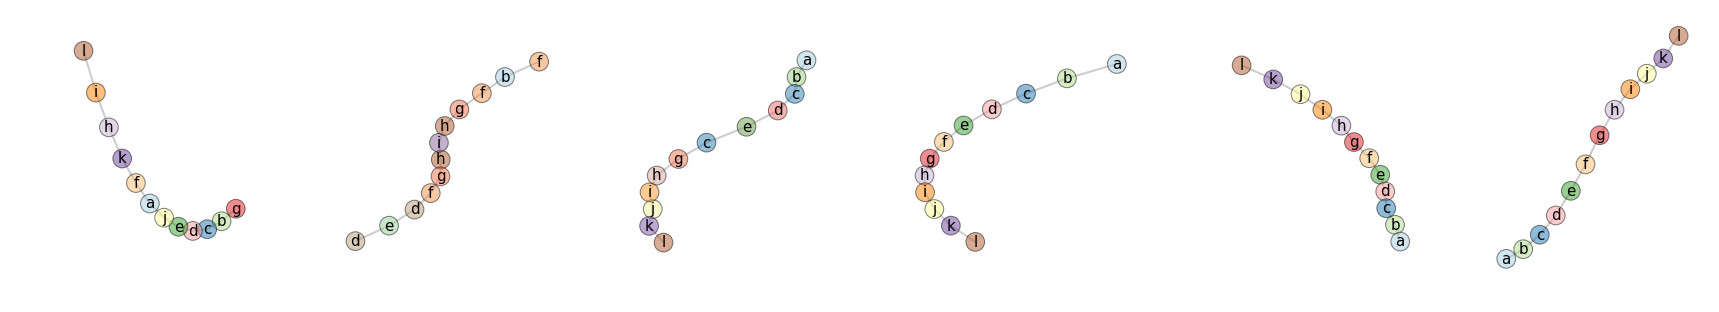

Graph id: 10


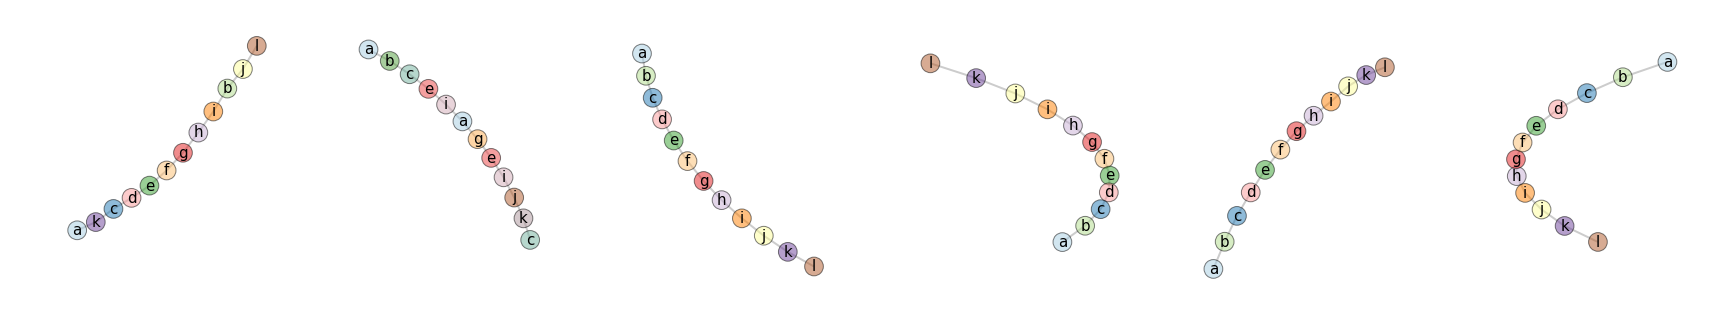

Graph id: 11


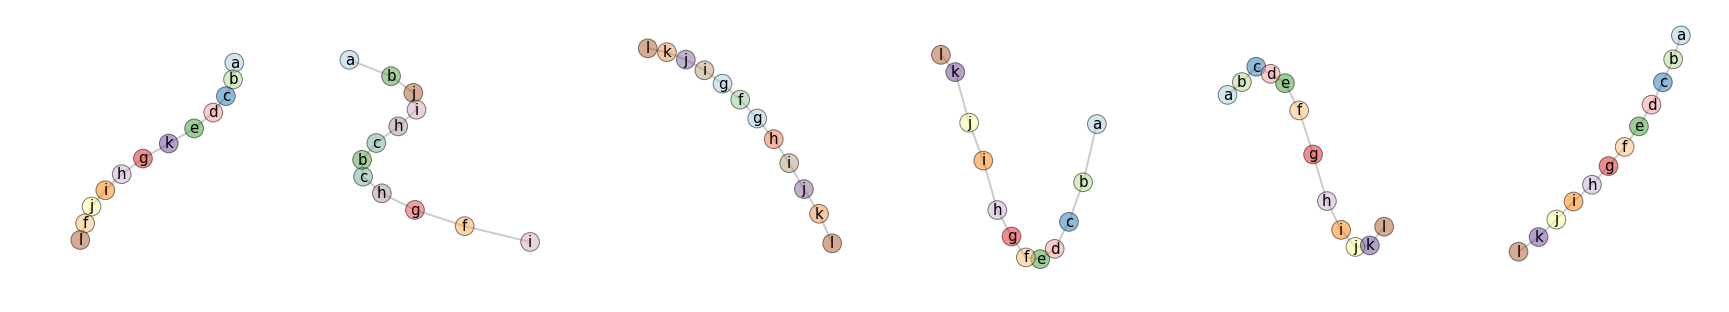

Graph id: 12


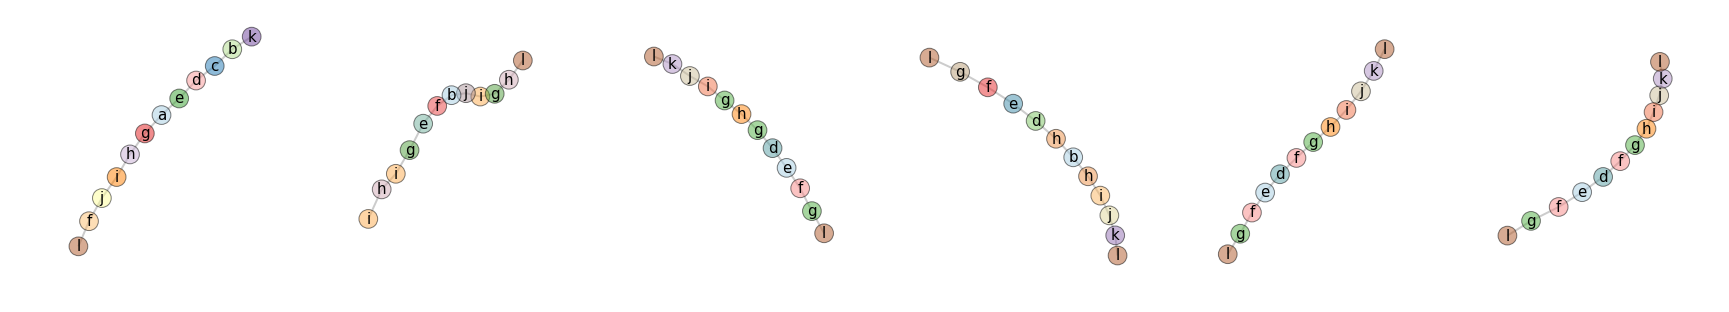

Graph id: 13


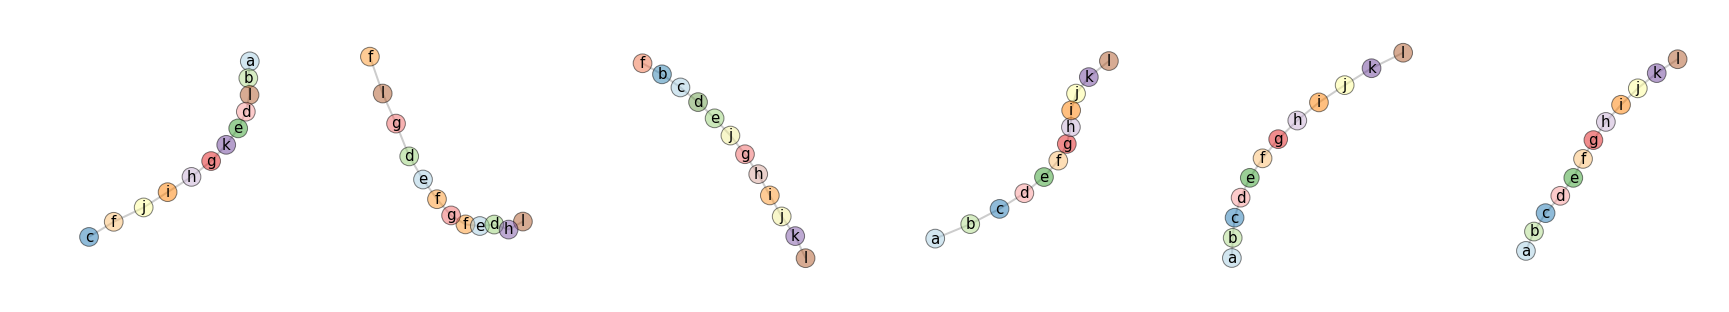

Graph id: 14


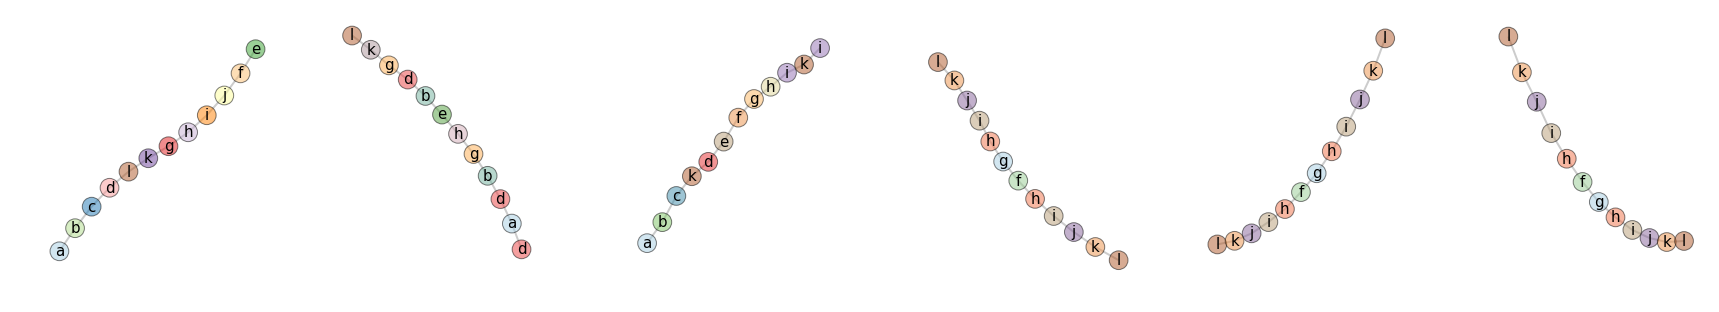

Graph id: 15


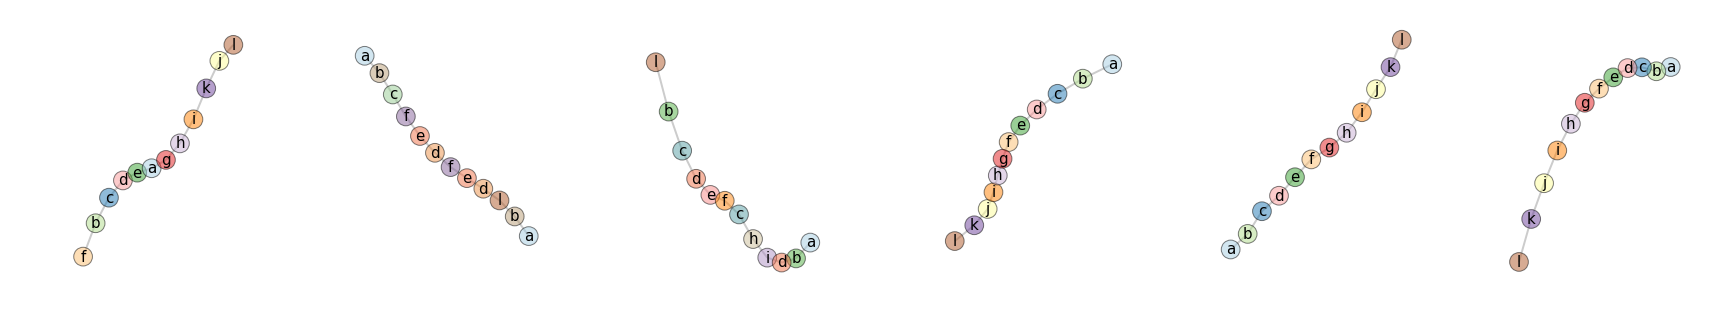

CPU times: user 29.6 s, sys: 2.16 s, total: 31.8 s
Wall time: 35.7 s


In [8]:
%%time
BABELDRAW=False
# for each graphlist that is yielded by the sampler:
scores=[]
ids=range(id_start,id_end)
for i,graphlist in enumerate(graphs):
    
    # collect scores of each graph that appeared during the sampling 
    print 'Graph id: %d'%(ids[i])
    scores.append(sampler.monitors[i].sampling_info['score_history'])
    
    # choose a drawing method.
    if BABELDRAW:
        # babel draw looks nice, but may lack detail
        from graphlearn.utils import openbabel
        openbabel.draw(graphlist, d3=False, n_graphs_per_line=6,size=200)
    else:
        from graphlearn.utils import draw
        # graphlearns drawing method is offering many options
        draw.graphlearn(graphlist,
                        contract=True,
                        n_graphs_per_line=6, 
                        size=5, 
                        colormap='Paired', 
                        invert_colormap=False,
                        node_border=0.5, 
                        vertex_color='_labels_',
                        vertex_alpha=0.5, 
                        edge_alpha=0.2, 
                        node_size=350)

# Show sample score history

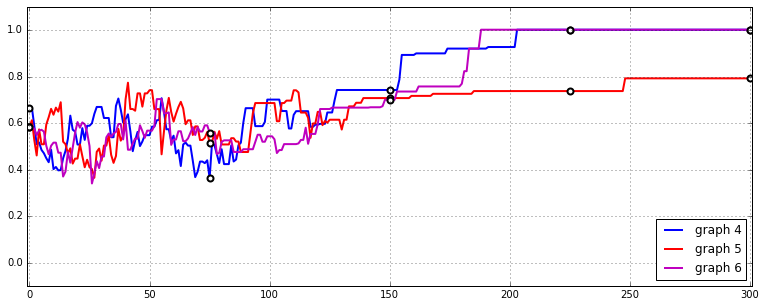

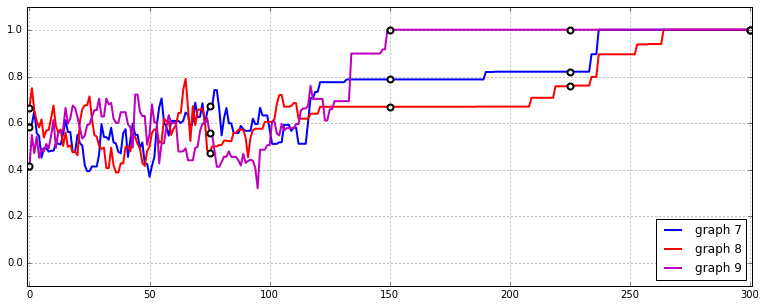

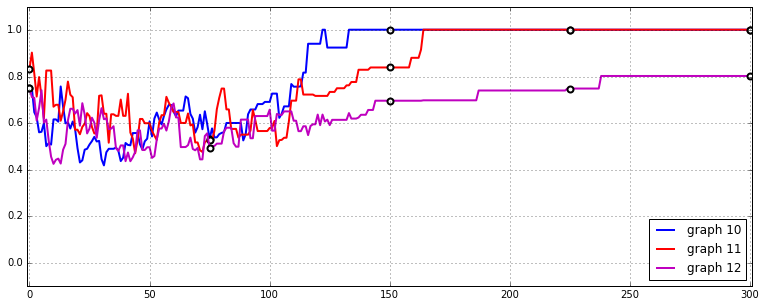

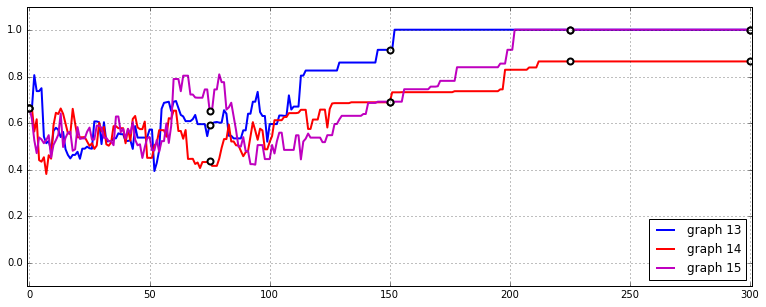

CPU times: user 800 ms, sys: 12 ms, total: 812 ms
Wall time: 811 ms


In [9]:
%%time
from itertools import islice
import numpy as np
import pylab as plt

markevery=n_steps/(n_samples)
step=1
num_graphs_per_plot=3
num_plots=np.ceil([len(scores)/num_graphs_per_plot])

for i in range(num_plots):
    plt.figure(figsize=(13,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
     
        data = list(islice(score,None, None, step))
        plt.plot(data, linewidth=2, label='graph %d'%(j+i*num_graphs_per_plot+id_start))
        plt.plot(data, linestyle='None',markevery=markevery, markerfacecolor='white', marker='o', markeredgewidth=2,markersize=6)
    plt.legend(loc='lower right')
    plt.grid()
    plt.xlim(-1,n_steps+1)
    plt.ylim(-0.1,1.1)
    plt.show()

---